<a href="https://colab.research.google.com/github/niyatisinghal/emotion-detection-using-tweets/blob/main/EMOTION_DETECTION_USING_TWEETS_DATASET_ml_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show nltk
!pip install --upgrade nltk

Name: nltk
Version: 3.8.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob


In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
!pip install stop_words
nltk.download('stopwords')
import pickle

from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=d6c3d7dd4ad46fe16b42810da30d63c61edd39f93ca6a93af6405ee220e5deaf
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/tweet_emotions.csv')
df.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [ ]:
# Find any numerical variables.
numerical = [var for var in df.columns if df[var].dtype!='O']

print('Num of numerical variables: {}\n'.format(len(numerical)))
print('The numerical variables are: ', numerical)

Num of numerical variables: 1

The numerical variables are:  ['tweet_id']


In [ ]:
df = df.drop(columns=['tweet_id'])
duplicates_count = df.duplicated().sum()
print(f'Total duplicated rows: {duplicates_count}')
df[df['content'].duplicated() == True]
index = df[df['content'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

Total duplicated rows: 91


In [ ]:
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [ ]:
frequency_counts = df['sentiment'].value_counts()

frequency_percentage = (frequency_counts / len(df['sentiment'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Print total value
cardinality = df['sentiment'].nunique()
print(f"\ntotal values: {cardinality}")

            Counts  Percentage
neutral       8598   21.588370
worry         8437   21.184121
happiness     5184   13.016295
sadness       5154   12.940970
love          3785    9.503603
surprise      2181    5.476184
fun           1775    4.456776
relief        1522    3.821528
hate          1322    3.319356
empty          822    2.063926
enthusiasm     758    1.903231
boredom        179    0.449444
anger          110    0.276195

total values: 13


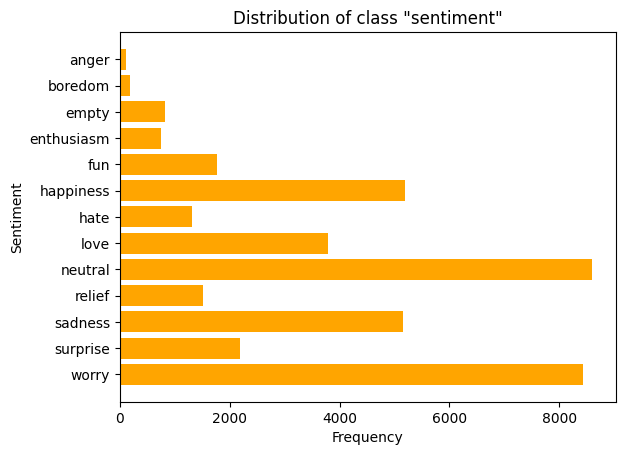

In [ ]:
# Extract sentiment values & frequencies
sentiment_counts = df['sentiment'].value_counts().sort_index()

sentiments = sentiment_counts.index
frequencies = sentiment_counts.values

# Plot
plt.barh(sentiments, frequencies, color='orange')
plt.xlabel('Frequency')
plt.ylabel('Sentiment')
plt.title('Distribution of class "sentiment"')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest sentiment at the top
plt.show()

In [ ]:
# Values from 'sentiment'
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [ ]:
sentiment_mapping = {
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive'
}
df['label'] = df['sentiment'].map(sentiment_mapping)

In [ ]:
df = df.drop(columns=['sentiment'])

In [ ]:
# Final check - Extract unique values from 'sentiment'
import pandas as pd

unique_sentiments = df['label'].unique()
print(unique_sentiments)

['negative' 'positive' 'neutral']


In [ ]:
df.head(10)

,content,label
0,@tiffanylue i know i was listenin to bad habi...,negative
1,Layin n bed with a headache ughhhh...waitin o...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,@dannycastillo We want to trade with someone w...,neutral
5,Re-pinging @ghostridah14: why didn't you go to...,negative
6,"I should be sleep, but im not! thinking about ...",negative
7,Hmmm. http://www.djhero.com/ is down,negative
8,@charviray Charlene my love. I miss you,negative
9,@kelcouch I'm sorry at least it's Friday?,negative


In [ ]:
# Calculate the frequency distribution of 'sentiment'
frequency_counts = df['label'].value_counts()

frequency_percentage = (frequency_counts / len(df['label'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Total value count
cardinality = df['label'].nunique()
print(f"\ntotal values: {cardinality}")

          Counts  Percentage
negative   16024   40.234012
positive   13024   32.701434
neutral    10779   27.064554

total values: 3


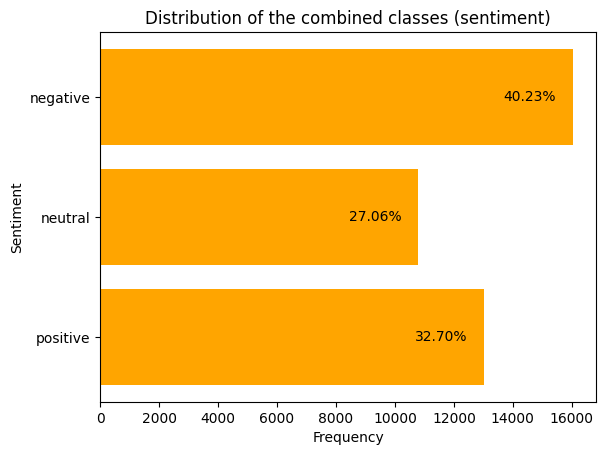

In [ ]:
sentiment_counts = df['label'].value_counts().sort_index()

# Extract sentiment values & frequencies
sentiments = sentiment_counts.index
frequencies = sentiment_counts.values

total = sum(frequencies)  # Calculate the total frequency

plt.barh(sentiments, frequencies, color='orange')
plt.xlabel('Frequency')
plt.ylabel('Sentiment')
plt.title('Distribution of the combined classes (sentiment)')
plt.gca().invert_yaxis()
for index, value in enumerate(frequencies):
    percentage = (value / total) * 100
    plt.text(value - (max(frequencies) * 0.09), index, f'{percentage:.2f}%', ha='center', va='center', color='black')

plt.show()

In [ ]:
# Mapping sentiment num / encode
df["label_num"] = df.label.map({
    'negative': 0,
    'positive': 1,
    'neutral': 2
})

df = df.drop(columns=['label'])
df.head(5)

,content,label_num
0,@tiffanylue i know i was listenin to bad habi...,0
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,1
4,@dannycastillo We want to trade with someone w...,2


In [ ]:
X = df['content']
y = df['label_num']

# Making sure that X y have the same length
print(len(X))
print(len(y))

39827
39827


In [ ]:
cleaned = []

for sen in range(0, len(X)):
    # Remove all the special characters (any letter or a digit)
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters (surrounded by whitespace)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    document = document.lower()

    # Lemmatization- splits into list of words ['The', 'quick', ....]
    document = document.split()

    lemma = WordNetLemmatizer()
    document = [lemma.lemmatize(word) for word in document]
    document = ' '.join(document)
    cleaned.append(document)

In [ ]:
# Making sure that cleaned data has the same length as X
len(cleaned)

39827

In [ ]:
nltk.download('punkt')
def count_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(text)
    return len(set(words) & stop_words)

# Add a new col 'stop_words' that contains the count of stopwords
df['stop_words'] = df['content'].apply(count_stopwords)
value_counts = df['stop_words'].value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Count the number of stopwords in the data
temp = df.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & stop_words))

# Print rows that contain stopwords
rows_with_stopwords = temp[temp['stop_words'] > 0]
print(rows_with_stopwords)

In [ ]:
# Count stopwords in index 3
stop_words = set(stopwords.words("english"))
df_indx = df['content'][3]
stopword_count = len([word for word in df_indx.split() if word in stop_words])
stopword_count

3

In [ ]:
stopwords_in_content = [word for word in df_indx.split() if word in stop_words]

print("Stopwords in df['content'][3]:")
print(stopwords_in_content)

Stopwords in df['content'][3]:
['to', 'out', 'with']


In [ ]:
cleaned_tokenized = []
for each in cleaned:
    doc = sent_tokenize(each)
    for sentence in doc:
        cleaned_tokenized.append(sentence)

# Type and length of the cleaned & tokenised sentence
print(type(cleaned_tokenized))
print(len(cleaned_tokenized))

# Print the fist 15 lines of the cleaned & tokenised sentence
for i in range(15):
  print(cleaned_tokenized[i])

<class 'list'>
39827
tiffanylue know wa listenin to bad habit earlier and started freakin at his part
layin bed with headache ughhhh waitin on your call
funeral ceremony gloomy friday
want to hang out with friend soon
dannycastillo we want to trade with someone who ha houston ticket but no one will
re pinging ghostridah14 why didn you go to prom bc my bf didn like my friend
i should be sleep but im not thinking about an old friend who want but he married now damn amp he want me 2 scandalous
hmmm http www djhero com is down
charviray charlene my love miss you
kelcouch m sorry at least it friday
cant fall asleep
choked on her retainer
ugh have to beat this stupid song to get to the next rude
brodyjenner if watch the hill in london will realise what tourture it is because were week and week late just watch itonlinelol
got the news


In [ ]:
df['processed_content'] = cleaned_tokenized

# Reorder col
desired_order = ['content', 'processed_content', 'label_num']
df = df[desired_order]
df.head(10)

X = cleaned_tokenized

In [ ]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)      # CV sparse matrix

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix) # tf-idf sparse matrix
# print(tf_idf_matrix)
dense_tf_idf_matrix = tf_idf_matrix.toarray()         # tf-idf dense matrix
# print(dense_tf_idf_matrix)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y, test_size=0.2, random_state=42)

Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.49      0.92      0.64     12834
           1       0.63      0.45      0.53     10395
           2       0.53      0.02      0.05      8632

    accuracy                           0.53     31861
   macro avg       0.55      0.47      0.41     31861
weighted avg       0.55      0.53      0.44     31861

Accuracy (Cross-Validation): 0.5254386240231004
Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.49      0.91      0.64      3190
           1       0.65      0.49      0.56      2629
           2       0.50      0.03      0.05      2147

    accuracy                           0.53      7966
   macro avg       0.55      0.48      0.42      7966
weighted avg       0.55      0.53      0.46      7966

Accuracy (Test Data): 0.5333919156414763


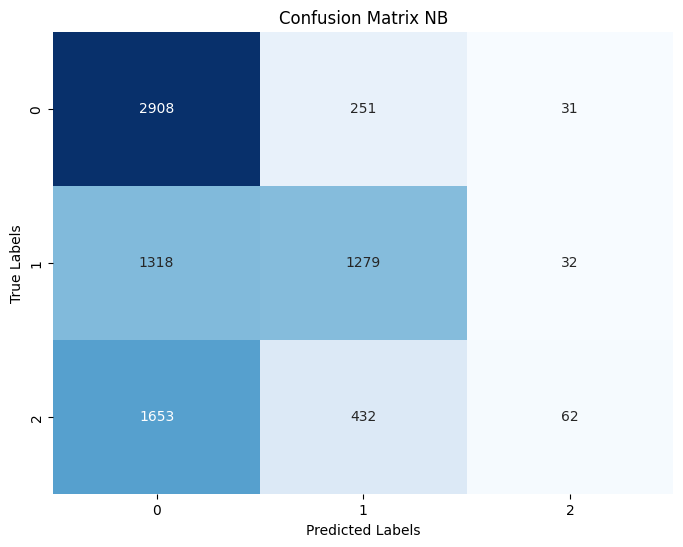

In [ ]:
model = MultinomialNB()

# Train
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Evaluate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)

classification_rep = classification_report(y_train, y_pred_cv)
print("Classification Report (Cross-Validation):\n", classification_rep)
accuracy = accuracy_score(y_train, y_pred_cv)
print("Accuracy (Cross-Validation):", accuracy)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

classification_rep_test = classification_report(y_test, y_pred_test)
print("Classification Report (Test Data):\n", classification_rep_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy (Test Data):", accuracy_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculating the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix NB')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5471
Precision: 0.5426
Recall: 0.5471
F1-score: 0.5442


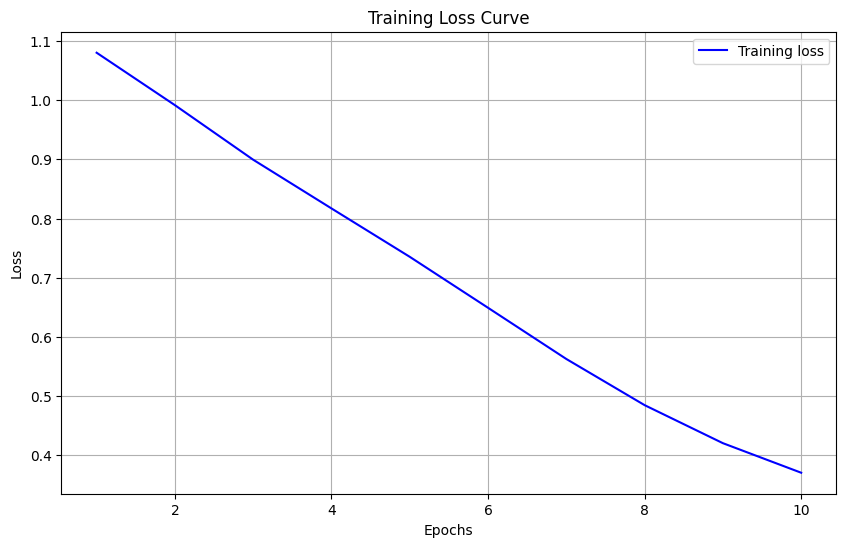

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(10, 10), alpha = 0.01, max_iter=10)

# Train
history = mlp_model.fit(X_train, y_train)

# Test
y_pred = mlp_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

train_loss = history.loss_curve_
num_epochs = len(train_loss)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Train
model = SVC()
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Evaluate
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67      3190
           1       0.65      0.59      0.62      2629
           2       0.48      0.35      0.41      2147

    accuracy                           0.59      7966
   macro avg       0.58      0.56      0.56      7966
weighted avg       0.58      0.59      0.58      7966

Accuracy: 0.5906351995982927


# New Section